This notebook shows how to preprocess and explore the dataset, finally creating k-folds for experiments.

# Imports

We will use the following libraries:
- **Pandas**, **NumPy**: data manipulation & analysis libraries ([documentation](https://pandas.pydata.org/docs/reference/index.html), [documentation](https://numpy.org/doc/stable/reference/)) - *for efficient data reading/manipulation*
- **Scikit-learn**: a machine learning library ([documentation](https://scikit-learn.org/stable/modules/classes.html)) - *here, for data splitting*
- **Matplotlib**: a visualization library ([documentation](https://matplotlib.org/stable/api/index.html)) - *for making plots about our data*
- Other standard python libraries such as **re** ([documentation](https://docs.python.org/3/library/re.html)) - *for matching sensible data for anonymization*

In [ ]:
# Import the needed libraries (and their functions)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
from sklearn.model_selection import StratifiedKFold

# Set the random seed
RANDOM_SEED = 42

# Load the dataset

We here load the dataset and subset it to match our experimental setup.

## Full dataset reading

First, we load the full dataset, including non-annotated tweets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the filepath to your dataset file
DATASET_FILEPATH = "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/raw/dataset-it.tsv"

# Load the (tab-separated: \t) dataset into a pandas dataframe
full_dataset = pd.read_csv(DATASET_FILEPATH, delimiter='\t')

# Normalize level1 class names
full_dataset['level1'].mask(full_dataset['level1'] == 'NOT-ABUSIVE', 'NOT ABUSIVE', inplace=True)
full_dataset['level1'].mask(full_dataset['level1'] == 'ABUS', 'ABUSIVE', inplace=True)

full_dataset.head(5)  # print the first 5 elements just for seeing the data

,id,date,level1,level2,level3,level4,level5,level1_context,level2_context,level3_context,level4_context,level5_context,context_used,notes,text,source_sample
0,1,2020-12-31T21:25:25.000Z,NOT ABUSIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I quaccheri cristiani sono solidali e condivid...,christianity
1,2,2020-12-31T20:05:32.000Z,NOT ABUSIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(FOTO) I cristiani dell'Iran, notte del capoda...",christianity
2,3,2020-12-31T18:33:42.000Z,ABUSIVE,OTHERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Fascisti a #capodanno, #fascisti per tutto l’a...",christianity
3,4,2020-12-31T15:57:09.000Z,NOT ABUSIVE,NaN,NaN,NaN,NaN,ABUS,IND,NaN,NaN,NaN,thread,IND: Papa Francesco,"@IlPrimatoN No problem, tanto avrebbe fatto il...",christianity
4,5,2020-12-31T14:37:37.000Z,ABUSIVE,GROUP,RELIGIOUS-HATE,ANTI-CHRISTIANITY,ANIMOSITY,NOT-ABUSIVE,NaN,NaN,NaN,NaN,thread,NaN,"@MarcoGiacomet11 @Agenzia_Ansa I ""cristiani fa...",christianity


## Dataset subsetting

We then subset data to contain annotated tweets only.

In [ ]:
# Create a new dataframe "dataset" containing all the rows having a non-NaN "level1" column value
dataset = full_dataset[full_dataset["level1"].isnull()==False]

# Remove unnecessary columns for these experiments from the resulting dataframe
dataset = dataset.drop(
    columns=["id", "date", "level1", "level2", "level4", "level5"])

# Convert "NaN" values to empty strings to make string operations work
dataset["level3"] = dataset["level3"].fillna('')

# Rename header columns: level3 -> label; text -> tweet
dataset = dataset.rename(columns={'level3': 'label', 'text': 'tweet'})
dataset.reset_index()

# Function used to decide which (religion-related) binary label to assign to the example
def is_religious_hate(data):
  if ('RELIGIOUS' in data['label']):
    return "RELIGIOUS HATE"
  else:
    return "NOT RELIGIOUS HATE"

# Overwrite the label (level3) column with the religious hate label
dataset['label'] = dataset.apply(is_religious_hate, axis=1)

dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet
0,NOT RELIGIOUS HATE,I quaccheri cristiani sono solidali e condivid...
1,NOT RELIGIOUS HATE,"(FOTO) I cristiani dell'Iran, notte del capoda..."
2,NOT RELIGIOUS HATE,"Fascisti a #capodanno, #fascisti per tutto l’a..."
3,NOT RELIGIOUS HATE,"@IlPrimatoN No problem, tanto avrebbe fatto il..."
4,RELIGIOUS HATE,"@MarcoGiacomet11 @Agenzia_Ansa I ""cristiani fa..."
5,RELIGIOUS HATE,@SteBiotech Contando i genocidi Cristiani su p...
6,NOT RELIGIOUS HATE,"L'anno convenzionale 2010 è stato tremendo, sp..."
7,NOT RELIGIOUS HATE,Un potente appello all'Imperatore chiedendo to...
8,NOT RELIGIOUS HATE,@MarcoAMunno Sì ma nessuno pensa ai poveri cri...
9,NOT RELIGIOUS HATE,"Anche in questo caso, un crimine perpetrato ai..."


In [ ]:
# Check the resulting number of annotated tweets in the dataset
print(dataset.shape)  # first value is #rows (tweets), second value is #cols

(3000, 2)


# Preprocess the dataset

Before using our data, there are some preprocessing steps we need to do. These are outlined in the following.

## Data cleaning

We create a new column with a cleaned version of the tweets, namely all lowercased, without special newline / non-standard characters.

In [ ]:
# Define the function that will do the cleaning
# Note: a function is informally a "general and reusable piece of code"
def clean_tweet(text):
  text = text.lower()                   # convert the text to lowercase
  text = text.replace("\n", " ")        # remove newline characters
  text = text.replace("\r", " ")        # remove newline characters (as above, but different encoding)
  text = text.replace(u'\xa0', u' ')    # remove non-standard characters (no-break space)
  text = text.replace(u'\u200d', u' ')  # remove non-standard characters (zero-width joiner)
  return text

# Do the actual cleaning on the "tweet" column of the dataframe
# Then convert the results to a list and put them on a new "tweet_preprocessed" column
dataset['tweet_preprocessed'] = list(map(clean_tweet, dataset.tweet))
dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet,tweet_preprocessed
0,NOT RELIGIOUS HATE,I quaccheri cristiani sono solidali e condivid...,i quaccheri cristiani sono solidali e condivid...
1,NOT RELIGIOUS HATE,"(FOTO) I cristiani dell'Iran, notte del capoda...","(foto) i cristiani dell'iran, notte del capoda..."
2,NOT RELIGIOUS HATE,"Fascisti a #capodanno, #fascisti per tutto l’a...","fascisti a #capodanno, #fascisti per tutto l’a..."
3,NOT RELIGIOUS HATE,"@IlPrimatoN No problem, tanto avrebbe fatto il...","@ilprimaton no problem, tanto avrebbe fatto il..."
4,RELIGIOUS HATE,"@MarcoGiacomet11 @Agenzia_Ansa I ""cristiani fa...","@marcogiacomet11 @agenzia_ansa i ""cristiani fa..."
5,RELIGIOUS HATE,@SteBiotech Contando i genocidi Cristiani su p...,@stebiotech contando i genocidi cristiani su p...
6,NOT RELIGIOUS HATE,"L'anno convenzionale 2010 è stato tremendo, sp...","l'anno convenzionale 2010 è stato tremendo, sp..."
7,NOT RELIGIOUS HATE,Un potente appello all'Imperatore chiedendo to...,un potente appello all'imperatore chiedendo to...
8,NOT RELIGIOUS HATE,@MarcoAMunno Sì ma nessuno pensa ai poveri cri...,@marcoamunno sì ma nessuno pensa ai poveri cri...
9,NOT RELIGIOUS HATE,"Anche in questo caso, un crimine perpetrato ai...","anche in questo caso, un crimine perpetrato ai..."


## Data anonymization

Tweets contain sensitive information (e.g., user mentions, URLs). We want to avoid keeping those for the following main reasons:
- It is a concern for privacy reasons and EU regulations;
- A model should not learn sensitive information about users and generalize based on that;
- Highly frequent user mentions or URLs would lead to undesidered biases / overfitting to spurious lexical items.

In [ ]:
# Define the patterns to match sensible information
# These use regular expressions exploiting the "re" library
USER_MENTION_PATTERN = re.compile(r"@\w*")  # e.g., @my_username
URL_PATTERN = re.compile(r"http\S+")        # e.g., http://www.example.com

# Define the function that will do the match and replacement
def anonymize_tweet(text):
  text = re.sub(USER_MENTION_PATTERN, "[USER]", text)
  text = re.sub(URL_PATTERN, "[URL]", text)
  return text

# Do the actual match and replacement on the "tweet_preprocessed" column of the dataframe
# We are actually overwriting the column created before with a further refined preprocessed version (i.e., anonymized)
dataset['tweet_preprocessed'] = list(map(anonymize_tweet, dataset.tweet_preprocessed))
dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet,tweet_preprocessed
0,NOT RELIGIOUS HATE,I quaccheri cristiani sono solidali e condivid...,i quaccheri cristiani sono solidali e condivid...
1,NOT RELIGIOUS HATE,"(FOTO) I cristiani dell'Iran, notte del capoda...","(foto) i cristiani dell'iran, notte del capoda..."
2,NOT RELIGIOUS HATE,"Fascisti a #capodanno, #fascisti per tutto l’a...","fascisti a #capodanno, #fascisti per tutto l’a..."
3,NOT RELIGIOUS HATE,"@IlPrimatoN No problem, tanto avrebbe fatto il...","[USER] no problem, tanto avrebbe fatto il soli..."
4,RELIGIOUS HATE,"@MarcoGiacomet11 @Agenzia_Ansa I ""cristiani fa...","[USER] [USER] i ""cristiani farlocchi"" sono una..."
5,RELIGIOUS HATE,@SteBiotech Contando i genocidi Cristiani su p...,[USER] contando i genocidi cristiani su popola...
6,NOT RELIGIOUS HATE,"L'anno convenzionale 2010 è stato tremendo, sp...","l'anno convenzionale 2010 è stato tremendo, sp..."
7,NOT RELIGIOUS HATE,Un potente appello all'Imperatore chiedendo to...,un potente appello all'imperatore chiedendo to...
8,NOT RELIGIOUS HATE,@MarcoAMunno Sì ma nessuno pensa ai poveri cri...,[USER] sì ma nessuno pensa ai poveri cristiani...
9,NOT RELIGIOUS HATE,"Anche in questo caso, un crimine perpetrato ai...","anche in questo caso, un crimine perpetrato ai..."


## Data deduplication

The presence of duplicates could lead to biases and unrealiable analyses and results. 

In our dataset we don't have any; however, we here show how to do this step for illustration purposes.

In [ ]:
# Remove duplicates based on the "tweet_preprocessed" column
dataset.drop_duplicates(subset={"tweet_preprocessed"}, inplace=True)
print(dataset.shape)  # first value is #rows (tweets), second value is #cols

(3000, 3)


# Explore the dataset

Getting into data before delving into more complex modeling decisions is crucial to understand what we are manipulating.

### Summary statistics

We notice the dataset is quite unbalanced; we can thus hypothesize that the underrepresented class(es) will be more difficult to predict.

Tot examples: 3000
NOT RELIGIOUS HATE    2443
RELIGIOUS HATE         557
Name: label, dtype: int64



Text(0, 0.5, 'Count')

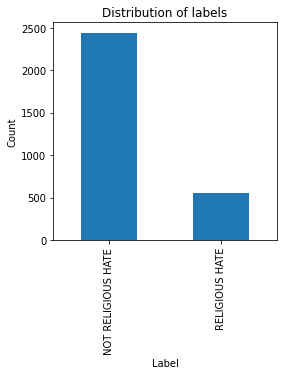

In [ ]:
tot_examples = dataset.shape[0]           # rows (first element) are number of examples
print(f"Tot examples: {tot_examples}")    # total number of examples
print(dataset["label"].value_counts())    # number of tweets per label
print()

# Plot the distribution of labels
ax = dataset["label"].value_counts().plot(kind='bar', figsize=(4,4))
fig = ax.get_figure()
ax.set_title("Distribution of labels")
ax.set_xlabel('Label')
ax.set_ylabel('Count')

# Create data splits

To run experiments, we need to split our dataset into training and test sets:
- **training set**: used for fitting the model (this is the largest split);
- **test set**: used for final performance evaluation of our model.

Using a single train/test split for evaluation is typically not enough, especially when the dataset is quite small. Indeed, the test portion may not be representative of the entire dataset. **K-fold cross-validation** is typically preferred (see [here](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation)). We will use its **stratified** version.

In [ ]:
# First, shuffle the rows in the dataset. This will avoid undesirable ordered splits
dataset = dataset.sample(frac=1, random_state=RANDOM_SEED)
dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet,tweet_preprocessed
1801,NOT RELIGIOUS HATE,@RobySimo80 Cosa che lei condivide ( lo ha pur...,[USER] cosa che lei condivide ( lo ha pure det...
1190,NOT RELIGIOUS HATE,@signordirettore @GiusCandela @heather_parisi ...,"[USER] [USER] [USER] la foto a destra è ""i med..."
1817,NOT RELIGIOUS HATE,@andreaborsoi1 @QuinziUgo Ora ti dirò una cosa...,"[USER] [USER] ora ti dirò una cosa, tra i musu..."
251,NOT RELIGIOUS HATE,Fuoco al clero. E Twitter grazia chi odia i cr...,fuoco al clero. e twitter grazia chi odia i cr...
2505,NOT RELIGIOUS HATE,@Yi_Benevolence vogliono ripetere l' esperienz...,[USER] vogliono ripetere l' esperienza dell' e...
1117,NOT RELIGIOUS HATE,"@micheleboldrin Se ci pensa, è esattamente qua...","[USER] se ci pensa, è esattamente quanto preve..."
1411,RELIGIOUS HATE,la mafia o meglio le mafie sono le comunità è ...,la mafia o meglio le mafie sono le comunità è ...
2113,NOT RELIGIOUS HATE,@Gio97380780 @lauraboldrini Per questa gente v...,[USER] [USER] per questa gente vengono prima i...
408,NOT RELIGIOUS HATE,Ho appena finito giorno 240 del 'Leggere la st...,ho appena finito giorno 240 del 'leggere la st...
2579,NOT RELIGIOUS HATE,@Adnkronos In primis ha assaggiato la cultura ...,[USER] in primis ha assaggiato la cultura isla...


In [ ]:
# Then, create K train/test set pairs
# The output will be stored on the data/ folder

# Create a list of texts and labels as numpy arrays
tweets_list = np.array(dataset["tweet_preprocessed"])
labels_list = np.array(dataset["label"])
X = np.array(tweets_list)
y = np.array(labels_list)

# Create the stratified k-fold cross-validator object (5 splits)
kf_object = StratifiedKFold(n_splits=5)

# Iterate over the 5 resulting folds' train/test indices
split_number = 1  # a counter for splits
for train_indices, test_indices in kf_object.split(X, y):
  # Subset the original dataset according to the indices
  curr_train = dataset.iloc[train_indices]
  curr_test = dataset.iloc[test_indices]

  # Remove unnecessary columns
  curr_train = curr_train.drop(columns=["tweet"])
  curr_test = curr_test.drop(columns=["tweet"])

  # Print statistics of the current split (#split_number)
  print(f"Split number: {split_number}.")
  print(f"- Train examples:          {curr_train.shape[0]}")
  print(f"  - RELIGIOUS HATE instances:      {curr_train['label'].value_counts()['RELIGIOUS HATE']}")
  print(f"  - NOT RELIGIOUS HATE instances:  {curr_train['label'].value_counts()['NOT RELIGIOUS HATE']}")
  print(f"- Test examples:            {curr_test.shape[0]}")
  print(f"  - RELIGIOUS HATE instances:       {curr_test['label'].value_counts()['RELIGIOUS HATE']}")
  print(f"  - NOT RELIGIOUS HATE instances:  {curr_test['label'].value_counts()['NOT RELIGIOUS HATE']}")
  print()

  # Define the train e test filepaths for the current split
  TRAIN_FILEPATH = "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/religious/train-it_" + str(split_number) + ".tsv"
  TEST_FILEPATH = "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/religious/test-it_" + str(split_number) + ".tsv"

  # Save the splits as tsv files (without header and index)
  curr_train.to_csv(TRAIN_FILEPATH, sep="\t", header=False, index=False)
  curr_test.to_csv(TEST_FILEPATH, sep="\t", header=False, index=False)

  split_number += 1 # increment the counter for splits

Split number: 1.
- Train examples:          2400
  - RELIGIOUS HATE instances:      446
  - NOT RELIGIOUS HATE instances:  1954
- Test examples:            600
  - RELIGIOUS HATE instances:       111
  - NOT RELIGIOUS HATE instances:  489

Split number: 2.
- Train examples:          2400
  - RELIGIOUS HATE instances:      446
  - NOT RELIGIOUS HATE instances:  1954
- Test examples:            600
  - RELIGIOUS HATE instances:       111
  - NOT RELIGIOUS HATE instances:  489

Split number: 3.
- Train examples:          2400
  - RELIGIOUS HATE instances:      446
  - NOT RELIGIOUS HATE instances:  1954
- Test examples:            600
  - RELIGIOUS HATE instances:       111
  - NOT RELIGIOUS HATE instances:  489

Split number: 4.
- Train examples:          2400
  - RELIGIOUS HATE instances:      445
  - NOT RELIGIOUS HATE instances:  1955
- Test examples:            600
  - RELIGIOUS HATE instances:       112
  - NOT RELIGIOUS HATE instances:  488

Split number: 5.
- Train examples:      